In [62]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
path_data = r"C:\Users\LaurèneDAVID\Documents\Teaching\Educational_apps\app-hec-AI-DS\data\classification\credit_score.csv"
credit_data = pd.read_csv(path_data)

# Credit score classification 

https://www.kaggle.com/datasets/parisrohan/credit-score-classification

## Data cleaning

In [3]:
type_loan_clean = []
for text in list(credit_data["Type_of_Loan"].unique()):
    text = text.replace(","," ")
    text = text.replace("loan","")
    text = text.replace("not specified","")
    text = text.replace("No Data","")
    text = text.replace("  "," ")
    text = text.strip()
    
    type_loan_clean.append(text)

In [4]:
all_type_loan = " ".join(type_loan_clean)
types_loan = list(set([loan for loan in all_type_loan.split(" ") if loan !=""]))

In [5]:
for loan in types_loan:
    credit_data[f"{loan.capitalize()}Loan"] = credit_data["Type_of_Loan"].apply(lambda x: 1 if loan in x else 0)

In [6]:
# Clean data
credit_data.drop(columns=["SSN","Name","Month","ID","Type_of_Loan","Payment_Behaviour"], inplace=True)
credit_data = credit_data.loc[~credit_data["Occupation"].isin(["Media_Manager","Manager"])]
credit_data["Age"] = credit_data["Age"].astype(int)

In [7]:
# Group customer data for numerical variables (mean)
num_columns = list(credit_data.select_dtypes(include=[float]).columns)
credit_data_num = credit_data[["Customer_ID"] + num_columns].groupby("Customer_ID").median().reset_index().round()

In [8]:
# Group customer data for categorical variables (mode)
cat_columns = list(credit_data.select_dtypes(include=[int,object]).columns)
credit_data_cat = credit_data[cat_columns].groupby("Customer_ID").apply(lambda group: group.mode().iloc[0] if not group.mode().empty else pd.Series(index=group.columns))
credit_data_cat = credit_data_cat.drop(columns=["Customer_ID"]).reset_index()

In [117]:
# Merge numerical and categorical merged datasets
credit_data_clean = credit_data_cat.merge(credit_data_num, on="Customer_ID", how="inner") # merge cleaned data for numerical and categorical variables
#credit_data_clean = credit_data_clean.sample(5000, random_state=0) # select 2000 samples randomly
credit_data_clean.reset_index(drop=True, inplace=True)
credit_data_clean.drop(columns=["Customer_ID"], inplace=True)

In [118]:
credit_data_clean = credit_data_clean.loc[credit_data_clean["Age"]>18]

In [119]:
credit_data_clean.head()

,Age,Occupation,Credit_Mix,Payment_of_Min_Amount,Credit_Score,HomeLoan,Credit-builderLoan,MortgageLoan,ConsolidationLoan,EquityLoan,...,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
0,38.0,Journalist,Standard,Yes,Poor,0.0,1.0,0.0,0.0,0.0,...,48.0,12.0,11.0,8.0,1942.0,33.0,186.0,27.0,45.0,317.0
1,37.0,Developer,Standard,Yes,Standard,0.0,0.0,0.0,0.0,0.0,...,26.0,11.0,14.0,10.0,1139.0,28.0,296.0,0.0,51.0,362.0
2,22.0,Accountant,Standard,Yes,Standard,0.0,1.0,0.0,0.0,0.0,...,19.0,18.0,17.0,7.0,982.0,36.0,334.0,188.0,101.0,567.0
3,44.0,Writer,Standard,Yes,Standard,0.0,0.0,0.0,0.0,0.0,...,20.0,14.0,15.0,6.0,1372.0,35.0,182.0,258.0,102.0,469.0
4,30.0,Mechanic,Good,No,Standard,1.0,0.0,1.0,0.0,1.0,...,9.0,2.0,3.0,1.0,1071.0,33.0,314.0,62.0,53.0,400.0


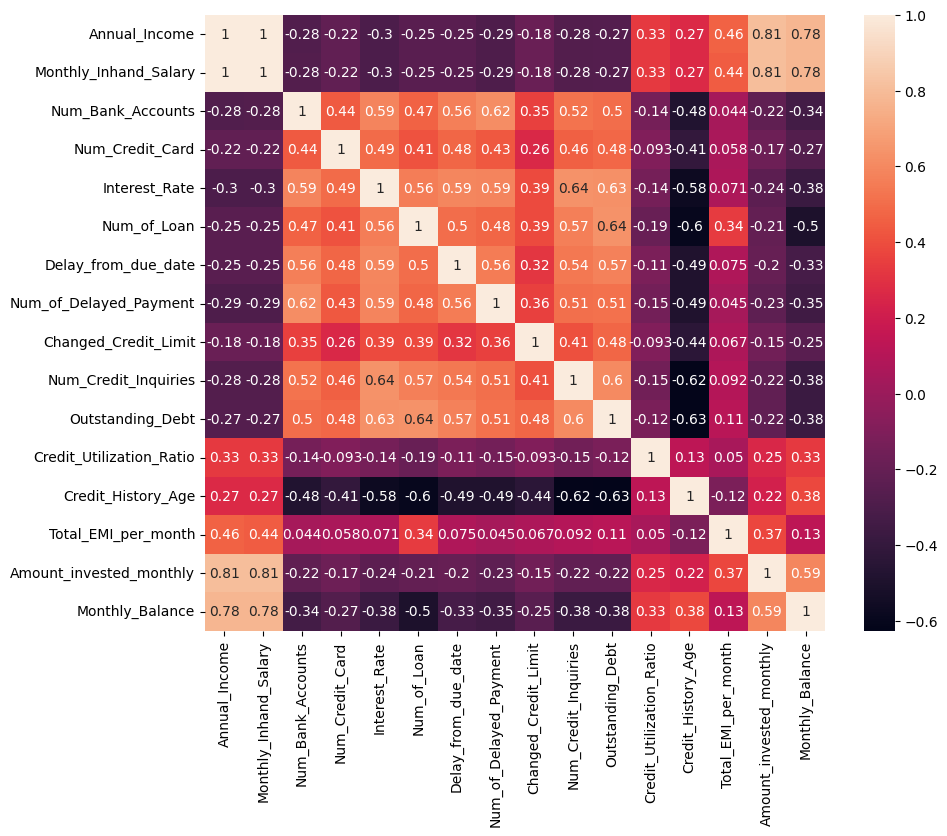

In [120]:
plt.figure(figsize=(10,8))
sns.heatmap(credit_data_clean[num_columns].corr(), annot=True)
plt.show()

In [121]:
drop_corr_columns = ["Monthly_Inhand_Salary","Amount_invested_monthly", "Num_Credit_Inquiries", 'Credit_Utilization_Ratio', 'Total_EMI_per_month', 'Monthly_Balance']
credit_data_clean.drop(columns=drop_corr_columns, inplace=True)
num_columns_clean = [col for col in num_columns if col not in drop_corr_columns]

In [122]:
# Identify possible outliers
credit_data_clean[num_columns_clean].describe().round(2)

,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Outstanding_Debt,Credit_History_Age
count,9943.00,9943.00,9943.00,9943.00,9943.00,9943.00,9943.00,9943.00,9943.00,9943.00
mean,51265.81,5.28,5.48,14.14,3.43,20.51,13.06,10.18,1379.43,225.71
std,38778.67,2.60,2.04,8.69,2.42,14.53,6.21,6.45,1136.02,99.17
min,7006.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,4.00
25%,19594.50,3.00,4.00,7.00,2.00,10.00,9.00,5.00,543.00,152.00
50%,37580.00,5.00,5.00,12.00,3.00,17.00,13.00,9.00,1123.00,224.00
75%,72899.50,7.00,7.00,20.00,5.00,27.00,18.00,14.00,1823.00,306.00
max,179987.00,10.00,11.00,34.00,9.00,62.00,25.00,30.00,4998.00,400.00


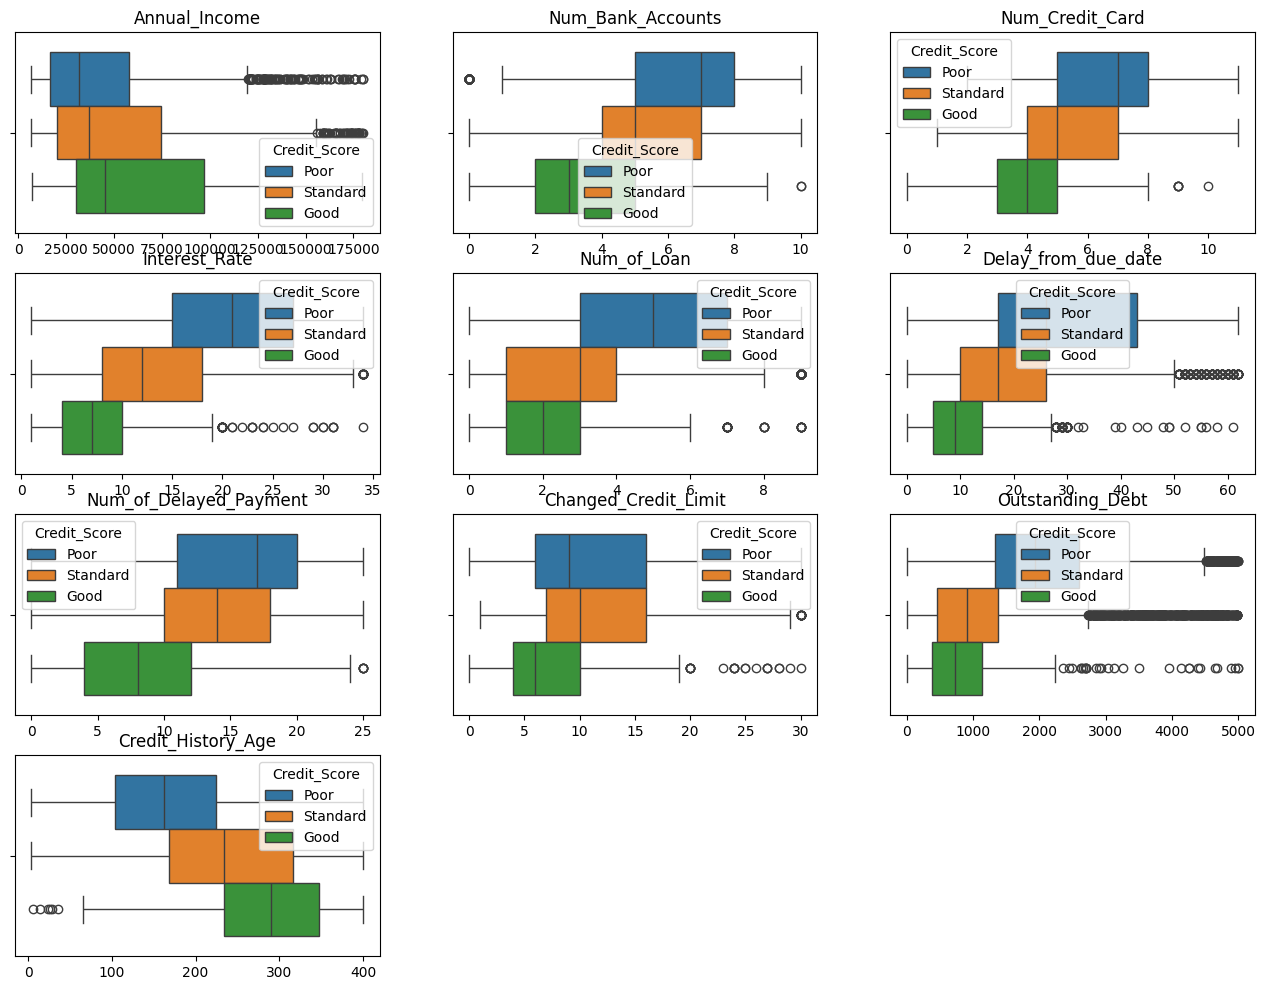

In [123]:
plt.figure(figsize=(16,12))
for i,col in enumerate(credit_data_clean[num_columns_clean].columns):
    plt.subplot(4,3,i+1)
    sns.boxplot(data=credit_data_clean, x=col, hue="Credit_Score", fill="Credit_Score")
    plt.xlabel("")
    plt.ylabel("")
    plt.title(str(col))

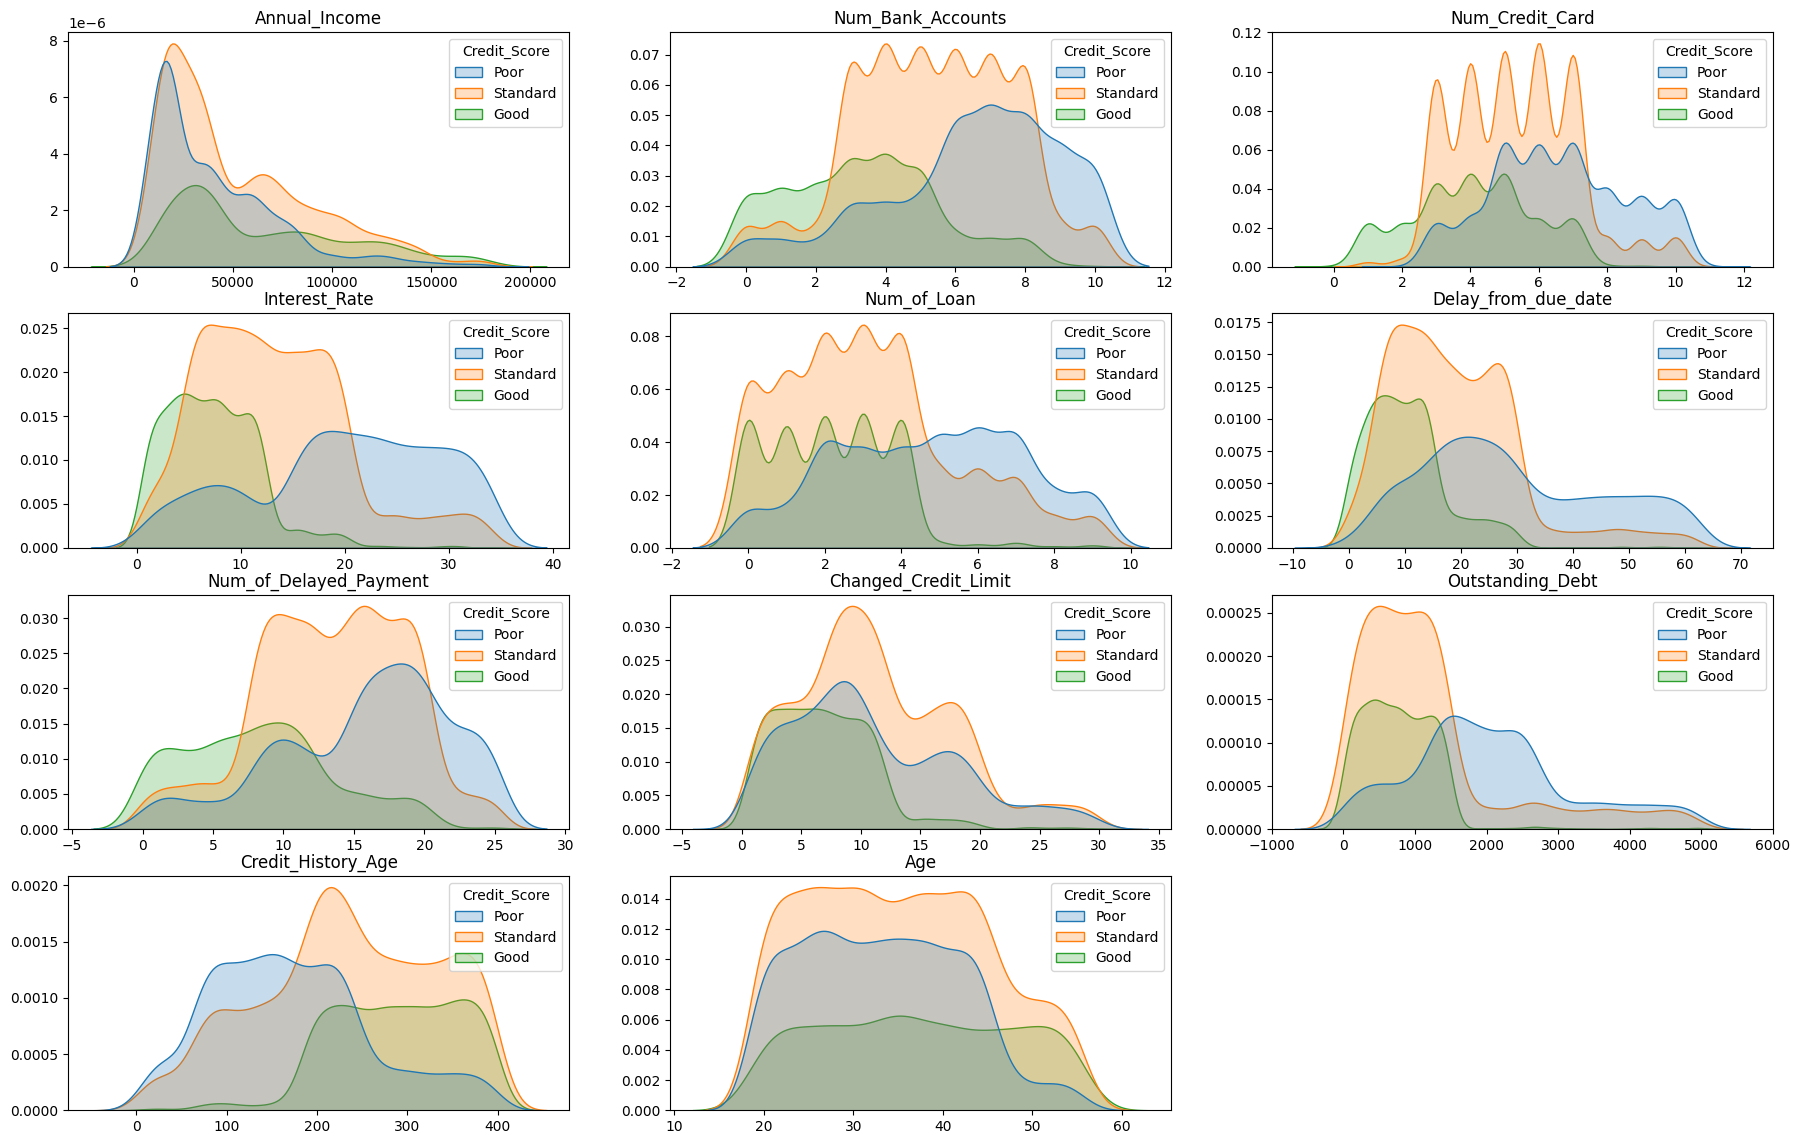

In [124]:
# Exploratory Data Analysis on numerical variables
plt.figure(figsize=(22,14))
for i,col in enumerate(list(credit_data_clean[num_columns_clean].columns) + ["Age"]):
    plt.subplot(4,3,i+1)
    sns.kdeplot(data=credit_data_clean, x=col, hue="Credit_Score", fill="Credit_Score")
    plt.xlabel("")
    plt.ylabel("")
    plt.title(str(col))

<Axes: xlabel='Credit Mix', ylabel='value'>

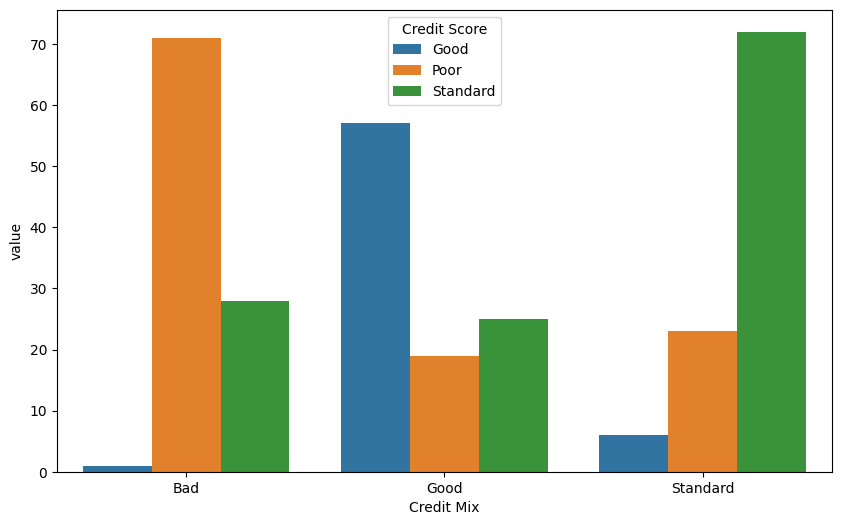

In [125]:
credit_occupation_df = pd.crosstab(credit_data_clean["Credit_Mix"], 
                                   credit_data_clean["Credit_Score"], normalize="index").apply(lambda x: np.round(100*x)).reset_index(drop=False)
credit_occupation_df.rename_axis(None, axis=1, inplace=True)
credit_occupation_df = credit_occupation_df.melt(id_vars=["Credit_Mix"])
credit_occupation_df.rename({"variable":"Credit Score", "Credit_Mix":"Credit Mix"}, axis=1, inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(data = credit_occupation_df, x="Credit Mix", y="value", hue="Credit Score")

In [126]:
credit_data_clean.drop(columns=[col for col in cat_columns if "Loan" in col], inplace=True)

In [129]:
X = credit_data_clean.drop(columns=["Credit_Score"])
y = credit_data_clean["Credit_Score"]

In [130]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [131]:
# Save training data for app
X_train_save = X_train.copy()
X_train_save["Credit_Score"] = y_train

path_savedata = r"C:\Users\LaurèneDAVID\Documents\Teaching\Educational_apps\app-hec-AI-DS\data\classification\credit_score"
X_train_save.to_pickle(os.path.join(path_savedata,"credit_score_train_raw.pkl"))

In [132]:
# Save test data for app
X_test_save = X_test.copy()
X_test_save.to_pickle(os.path.join(path_savedata,"credit_score_test_raw.pkl"))

In [133]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder

cat_columns_clean = [col for col in cat_columns if col not in ["Customer_ID","Credit_Score","Age"]]
cat_columns_clean = [col for col in cat_columns_clean if "Loan" not in col]
num_columns_clean.append("Age")

# Build data processing pipeline
ct = ColumnTransformer(
    [("numerical", RobustScaler(), num_columns_clean), 
     ("categorical", OneHotEncoder(sparse_output=False), cat_columns_clean)],
     remainder='passthrough')

X_train_pp = ct.fit_transform(X_train)
X_test_pp = ct.transform(X_test)

In [134]:
columns_transform = [col.split("__")[1] for col in ct.get_feature_names_out()]
df_clean = pd.DataFrame(X_train_pp, columns=columns_transform)
df_clean.head()

,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Outstanding_Debt,Credit_History_Age,...,Occupation_Musician,Occupation_Scientist,Occupation_Teacher,Occupation_Writer,Credit_Mix_Bad,Credit_Mix_Good,Credit_Mix_Standard,Payment_of_Min_Amount_NM,Payment_of_Min_Amount_No,Payment_of_Min_Amount_Yes
0,0.472788,-1.25,-0.333333,-0.846154,-0.333333,-0.388889,-0.111111,-0.777778,-0.640219,1.116883,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-0.074266,-0.25,-0.333333,-0.307692,-1.000000,-0.388889,-1.000000,-0.444444,-0.639437,-0.051948,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.693351,-0.50,-0.666667,-0.384615,-1.000000,0.277778,0.111111,1.222222,-0.727770,-0.129870,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,-0.039409,0.00,0.000000,-0.692308,-0.666667,-0.388889,-1.333333,0.000000,-0.314247,0.389610,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.402867,1.00,1.333333,1.538462,2.000000,0.944444,0.444444,0.777778,1.212429,-0.961039,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [135]:
X_test_save_pp = X_test_pp.copy()
X_test_save_pp = pd.DataFrame(X_test_save_pp, columns=columns_transform)
X_test_save_pp.to_pickle(os.path.join(path_savedata,"credit_score_test_pp.pkl"))

In [136]:
import lightgbm as lgb

params = {
'boosting_type': 'gbdt',
'num_leaves': 30,
'learning_rate': 0.05,
'feature_fraction': 0.9
}

clf = lgb.LGBMClassifier()
clf.fit(X_train_pp, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 968
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 30
[LightGBM] [Info] Start training from score -1.553557
[LightGBM] [Info] Start training from score -1.134150
[LightGBM] [Info] Start training from score -0.761832


LGBMClassifier()

In [137]:
from sklearn.metrics import accuracy_score

y_pred_lgb_train = clf.predict(X_train_pp)
print("Accuracy", accuracy_score(y_train, y_pred_lgb_train))

Accuracy 0.8900862068965517


In [138]:
y_pred_lgb_test = clf.predict(X_test_pp)
print("Accuracy", accuracy_score(y_test, y_pred_lgb_test))

Accuracy 0.7525980556486759


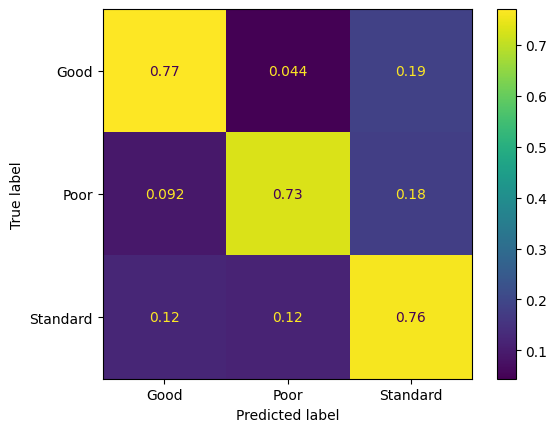

In [139]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_lgb_test, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [140]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

rf = RandomForestClassifier(max_depth=14, class_weight="balanced_subsample", n_estimators=600)
rf.fit(X_train_pp, y_train)

y_pred_rf_train = rf.predict(X_train_pp)
y_pred_rf_test = rf.predict(X_test_pp)

print("Train Accuracy", accuracy_score(y_train, y_pred_rf_train))
print("Test Accuracy", accuracy_score(y_test, y_pred_rf_test))

Train Accuracy 0.8853448275862069
Test Accuracy 0.7509218907140462


In [141]:
df_train_results = pd.DataFrame({"y_pred":y_pred_rf_train, 
                                 "y_true":y_train})

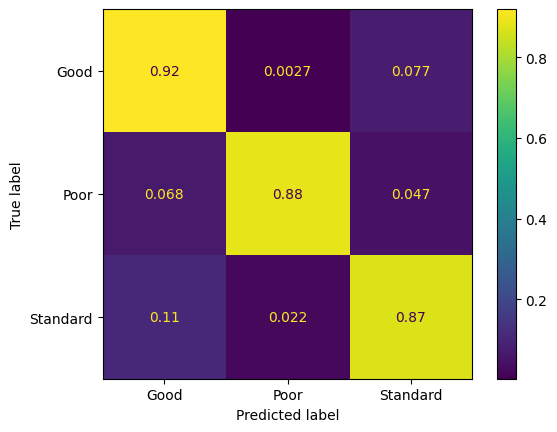

In [142]:
cm = confusion_matrix(y_train, y_pred_rf_train, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()

In [143]:
df_cm = pd.DataFrame(cm, columns=["Good","Poor","Standard"])
#df_cm.insert(0,"Label",["Good","Poor","Standard"])
df_cm.to_pickle(os.path.join(path_savedata,"credit_score_cm_train"))

In [144]:
import pickle

path_model = r"C:\Users\LaurèneDAVID\Documents\Teaching\Educational_apps\app-hec-AI-DS\pretrained_models\supervised_learning"
with open(os.path.join(path_model,'credit_score_model.pkl'),'wb') as f:
    pickle.dump(rf,f)